**IMPORTAÇÃO DAS BIBLIOTECAS**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

<ipython-input-1-dbfbcd6df5b2>:5: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  from pandas_profiling import ProfileReport


**IMPORTAÇÃO DOS DADOS EM CSV**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:

df_demo = pd.read_csv('/content/drive/MyDrive/COLAB COPIAS/testes projeto/BDIPMamaV11-INTELIDemograficosTt_DATA_LABELS_2023-01-24_1922.csv')
df_hist = pd.read_csv('/content/drive/MyDrive/COLAB COPIAS/testes projeto/BDIPMamaV11-INTELIHistopatologia_DATA_LABELS_2023-01-24_1924.csv')
df_peso = pd.read_csv('/content/drive/MyDrive/COLAB COPIAS/testes projeto/BDIPMamaV11-INTELIPesoEAltura_DATA_LABELS_2023-01-24_1926.csv')
df_tumor = pd.read_csv('/content/drive/MyDrive/COLAB COPIAS/testes projeto/BDIPMamaV11-INTELIRegistroDeTumo_DATA_LABELS_2023-01-24_1924.csv')


**SELEÇÃO PRIMÁRIA DE TABELAS**  

In [4]:
df_demo = df_demo[['Record ID', 'Escolaridade', 'Idade do paciente ao primeiro diagnóstico', 'Sexo', 'Data da última informação sobre o paciente', 'Última informação do paciente', 'Tempo de seguimento (em dias) - desde o último tumor no caso de tumores múltiplos    [dt_pci]', 'Já ficou grávida?', 'Idade na primeira gestação', 'Amamentou na primeira gestação?', 'Por quanto tempo amamentou?', 'Idade da primeira mentruação', 'Já fez uso de drogas?',	'Atividade Física',	'Consumo de tabaco',	'Consumo de álcool', 'Possui histórico familiar de câncer?', 'Regime de Tratamento']]


df_peso = df_peso[['Record ID','Peso', 'Altura (em centimetros)', 'IMC']]


df_tumor = df_tumor[['Record ID', 'Código da Topografia (CID-O)', 'Código da Morfologia de acordo com o CID-O', 'Estadio Clínico  ', 'Grupo de Estadio Clínico', 'Classificação TNM Clínico - T', 'Classificação TNM Clínico - N', 'Classificação TNM Clínico - M', 'Combinação dos Tratamentos Realizados no Hospital', 'Lateralidade do tumor', 'Tempo desde o diagnóstico até a primeira recidiva  ', 'Descrição da Morfologia de acordo com o CID-O  (CID-O - 3ª edição)', 'Descrição da Topografia ', 'Com recidiva à distância', 'Com recidiva regional', 'Com recidiva local']]


df_hist = df_hist.drop(columns='Indice H (Receptorde progesterona)')



***LIMPEZA DE LINHAS TOTALMENTE VAZIAS OU POBRES DE CONTEÚDO***

In [5]:
#não foi necessário fazer esse processo com o df_demo

df_tumor = df_tumor[df_tumor.isnull().sum(axis=1) < 14]

df_peso = df_peso[df_peso.isnull().sum(axis=1) < 3]

df_hist = df_hist[df_hist.isnull().sum(axis=1) < 10]

print(df_tumor.shape)
print(df_peso.shape)
print(df_hist.shape)
print(df_demo.shape)
print(df_peso['Record ID'].value_counts())

(4677, 16)
(51334, 4)
(4787, 14)
(4272, 18)
12321    96
39366    83
30317    80
18944    75
16927    73
         ..
30261     1
72964     1
49325     1
50244     1
73132     1
Name: Record ID, Length: 3801, dtype: int64


*TRATAMENTO DA TABELA **PESO** PARA EVITAR REPETIÇÕES* // TRATAMENTO DE OUTLIERS

In [6]:
#SETANDO O NUMERO DE CASAS DECIMAIS
pd.set_option('display.precision',1)

menores = df_peso[(df_peso.IMC > 5)]
maiores = menores[(menores.IMC < 50)]


#Agrupando por ID e colocando a média 
df_peso = maiores[(maiores.IMC != np.inf)].groupby(['Record ID'], as_index=False).mean()

#pegar só a ultima ocorrencia

RETIRANDO LINHAS COM MAIS DE UMA OCORRÊNCIA, **MANTENDO O ÚLTIMO REGISTRO**

In [7]:


df_hist = df_hist.drop_duplicates(subset=['Record ID'], keep='last')
df_tumor = df_tumor.drop_duplicates(subset=['Record ID'], keep='last')

print(df_peso['Record ID'].nunique())
print(df_hist['Record ID'].nunique())
print(df_tumor['Record ID'].nunique())
print(df_demo['Record ID'].nunique())

print('-----------------')

print(df_peso['Record ID'].value_counts().sum())
print(df_hist['Record ID'].value_counts().sum())
print(df_tumor['Record ID'].value_counts().sum())
print(df_demo['Record ID'].value_counts().sum())

3746
4272
4272
4272
-----------------
3746
4272
4272
4272


**MERGE DAS TABELAS**

In [8]:
df_merge = df_demo.merge(df_tumor)
df_merge = df_merge.merge(df_hist)
df_merge = df_merge.merge(df_peso)

df_dados = df_merge
df_dados.isnull().sum()

Record ID                                                                                           0
Escolaridade                                                                                      203
Idade do paciente ao primeiro diagnóstico                                                         169
Sexo                                                                                              139
Data da última informação sobre o paciente                                                          2
Última informação do paciente                                                                       2
Tempo de seguimento (em dias) - desde o último tumor no caso de tumores múltiplos    [dt_pci]       2
Já ficou grávida?                                                                                2800
Idade na primeira gestação                                                                       2914
Amamentou na primeira gestação?                                                   



**SELEÇÃO DE COLUNAS ESPECÍFICAS PARA TRABALHAR**

In [9]:
dfz = df_dados[['Record ID', 'Idade do paciente ao primeiro diagnóstico', 'Última informação do paciente', 'Tempo de seguimento (em dias) - desde o último tumor no caso de tumores múltiplos    [dt_pci]', 'Já ficou grávida?', 'Regime de Tratamento', 'Classificação TNM Clínico - M', 'Classificação TNM Clínico - N', 'Classificação TNM Clínico - T', 'Lateralidade do tumor', 'Com recidiva à distância', 'Com recidiva regional', 'Com recidiva local', 'Estadio Clínico  ', 'Combinação dos Tratamentos Realizados no Hospital']]
for coluna in dfz:
  print(f"{df_dados[coluna].unique()}---")



[  302   710   752 ... 82131 82205 82240]---
[51. 58. 56. 63. 42. 43. 52. 40. 60. 29. 36. 75. 45. 31. 30. 71. 48. 50.
 39. 49. 61. 47. 55. 74. 37. 59. 32. 64. 44. 35. 57. 62. 54. 68. 33. 78.
 27. 28. 46. 69. 80. 34. 82. 70. 41. 65. 73. 53. 72. 22. 66. 26. 38. 81.
 79. 25. 24. 83. 86. 67. 84. 91. 76. 77. 89. 85. 87. 92. 23. 90. 95. 88.
 98. nan 96.]---
['Obito por câncer' 'Vivo, SOE' 'Vivo, com câncer'
 'Óbito por outras causas, SOE' nan]---
[2225. 3294. 4153. ...  391.  366.  138.]---
[nan 'Sim' 'Não']---
[nan 'Terapia Adjuvante' 'Terapia Neoadjuvante' 'Paliativo'
 'Não fez quimioterapia']---
['0' '1' 'Y: Na' 'X - nao foi possivel determinar' '1B' '1A']---
['0' '1' '2' '3' 'X - nao foi possivel determinar' '3C' '2A' '3A' 'Y: Na'
 '1B' '2B' '3B' '1A']---
['2' '3' '1' '1C' '4' 'X - nao foi possivel determinar' '4B' '3A' '1A'
 '1B' 'Y: Na' '4D' 'IS' '4A' '0' '4C' 'CDIS' '3B' '2B' '1MIC' '2A' 'CLIS']---
['Esquerda' 'Direita' 'não se aplica' 'Bilateral']---
['Não' 'Sim']---
['Não' 'Sim']---

TRATAMENTO DE MISSINGS DAS COLUNAS SELECIONADAS

In [10]:
pd.set_option('display.precision',0)

tes = dfz.dropna(subset=['Última informação do paciente'])
tes2 = dfz.dropna(subset=['Última informação do paciente'])


tes2['Idade do paciente ao primeiro diagnóstico'].fillna(tes['Idade do paciente ao primeiro diagnóstico'].describe()['mean'], inplace= True)
#Aqui escolhemos substituir a idade com média temporariamente para poder fazer a analise dos dados e depois modificamos novamente para "0", para facilitar o reconhecimento de dados ausentes na hora da codificação
tes2['Já ficou grávida?'].fillna("Não Informado Gravida", inplace= True)
tes2['Regime de Tratamento'].fillna("Não Informado Tratamento", inplace= True)


tes['Idade do paciente ao primeiro diagnóstico'].fillna("0", inplace= True)
tes['Já ficou grávida?'].fillna("Não Informado Gravida", inplace= True)
tes['Regime de Tratamento'].fillna("Não Informado Tratamento", inplace= True)

#EMBORA TENHA SIDO UTILIZADO DF2 PARA ANALISES, A CONTINUIDADE DO CÓDIGO SE DARÁ COM O DF1 PORQUE ELE ESTÁ COM A IDADE ADAPTADA PARA SER CODIFICADA


/usr/local/lib/python3.8/dist-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


**TRATAMENTO DE ALGUNS OUTLIERS DAS COLUNAS SELECIONADAS**

In [11]:
#ELIMINANDO PACIENTES ACIMA DE 90 ANOS PORQUE POSSUIMOS POUCAS AMOSTRAGENS ACIMA DESSA FAIXA ETÁRIA E PARA EVITAR UNDERFITTING
index_idade = tes2[ (tes2['Idade do paciente ao primeiro diagnóstico'] >= 90)].index
tes2.drop(index_idade, inplace = True)
tes.drop(index_idade, inplace = True)

#ELIMINANDO PACIENTES QUE POSSUEM REGISTRO DE TUMOR ABAIXO DE 20 DIAS PORQUE ISSO É MUITO POUCO E PROVAVELMENTE A DATA ESTÁ BUGADA
index_diastumor = tes2[ (tes2['Tempo de seguimento (em dias) - desde o último tumor no caso de tumores múltiplos    [dt_pci]'] <= 20)].index
tes2.drop(index_diastumor, inplace = True)
tes.drop(index_diastumor, inplace = True)


/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


**RECONHECIMENTO DE COLUNAS NUMÉRICAS X COLUNAS CATEGÓRICAS**

In [33]:
cont = 0
listacolcat = []
for coluna in tes2.dtypes:
  if coluna == 'float64' or coluna == 'int64':
    tipo = "Coluna Númerica"

  elif coluna == object:
      tipo = "Coluna Categórica"
      listacolcat.append(tes2.columns[cont])
      
  print(f'{tes2.columns[cont]} é {tipo}\n========\n')
  cont+=1

#print(tes2.dtypes == 'O')

Record ID é Coluna Númerica

Idade do paciente ao primeiro diagnóstico é Coluna Númerica

Última informação do paciente é Coluna Categórica

Tempo de seguimento (em dias) - desde o último tumor no caso de tumores múltiplos    [dt_pci] é Coluna Númerica

Já ficou grávida? é Coluna Categórica

Regime de Tratamento é Coluna Categórica

Classificação TNM Clínico - M é Coluna Categórica

Classificação TNM Clínico - N é Coluna Categórica

Classificação TNM Clínico - T é Coluna Categórica

Lateralidade do tumor é Coluna Categórica

Com recidiva à distância é Coluna Categórica

Com recidiva regional é Coluna Categórica

Com recidiva local é Coluna Categórica

Estadio Clínico   é Coluna Categórica

Combinação dos Tratamentos Realizados no Hospital é Coluna Categórica



['Última informação do paciente',
 'Já ficou grávida?',
 'Regime de Tratamento',
 'Classificação TNM Clínico - M',
 'Classificação TNM Clínico - N',
 'Classificação TNM Clínico - T',
 'Lateralidade do tumor',
 'Com recidiva à distância',
 'Com recidiva regional',
 'Com recidiva local',
 'Estadio Clínico  ',
 'Combinação dos Tratamentos Realizados no Hospital']

  **ESTATÍSTICA DESCRITIVA DAS COLUNAS NÚMERICAS**
  

In [13]:
tes2.describe()


,Record ID,Idade do paciente ao primeiro diagnóstico,Tempo de seguimento (em dias) - desde o último tumor no caso de tumores múltiplos [dt_pci]
count,3726,3726,3726
mean,49219,54,1501
std,20989,13,842
min,302,22,25
25%,30608,45,1008
50%,54701,54,1301
75%,67576,63,1837
max,82240,89,4503


**ESTATÍSTICA DESCRITIVA DAS COLUNAS CATEGÓRICAS**

In [42]:
for coluna in listacolcat:
  print(f'Coluna:{coluna}\n\n{tes2[coluna].value_counts()}\n\n\n') 

Coluna:Última informação do paciente

Vivo, SOE                       2536
Obito por câncer                 910
Vivo, com câncer                 218
Óbito por outras causas, SOE      62
Name: Última informação do paciente, dtype: int64



Coluna:Já ficou grávida?

Não Informado Gravida    2787
Sim                       928
Não                        11
Name: Já ficou grávida?, dtype: int64



Coluna:Regime de Tratamento

Terapia Adjuvante           1275
Não Informado Tratamento    1195
Terapia Neoadjuvante        1176
Paliativo                     55
Não fez quimioterapia         25
Name: Regime de Tratamento, dtype: int64



Coluna:Classificação TNM Clínico - M

0                                  3249
1                                   445
Y: Na                                16
X - nao foi possivel determinar       7
1B                                    6
1A                                    3
Name: Classificação TNM Clínico - M, dtype: int64



Coluna:Classificação TNM Clínico - 

**3 GRÁFICOS RELACIONAIS ENTRE VARIÁVEIS ESCOLHIDAS PELO GRUPO**


Aqui relacionamos a idade do paciente e o tempo desde o último tumor

<AxesSubplot:xlabel='Idade do paciente ao primeiro diagnóstico', ylabel='Tempo de seguimento (em dias) - desde o último tumor no caso de tumores múltiplos    [dt_pci]'>

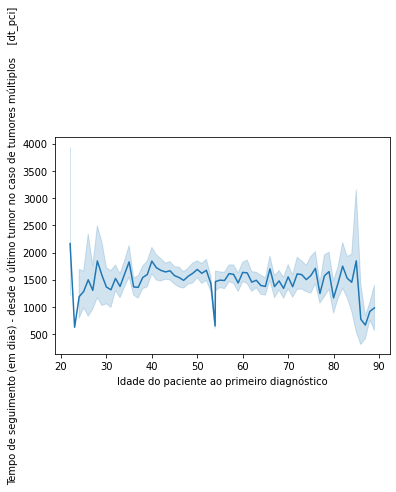

In [14]:

sns.lineplot(data=tes2, x='Idade do paciente ao primeiro diagnóstico', y='Tempo de seguimento (em dias) - desde o último tumor no caso de tumores múltiplos    [dt_pci]')



Nesse outro gráfico relacionamos a situação do paciente com sua idade e explicitamos o regime de tratamento utilizado de cada um

<AxesSubplot:xlabel='Última informação do paciente', ylabel='Idade do paciente ao primeiro diagnóstico'>

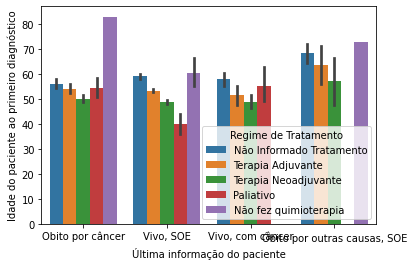

In [15]:
sns.barplot(data=tes2, x="Última informação do paciente", y="Idade do paciente ao primeiro diagnóstico", hue="Regime de Tratamento")

Por último, nesse gráfico tentamos enxergar a relação entre a lateralidade do tumor e o tempo desde o último tumor, e novamente tentamos explicitar qual foi o regime de tratamento utilizado

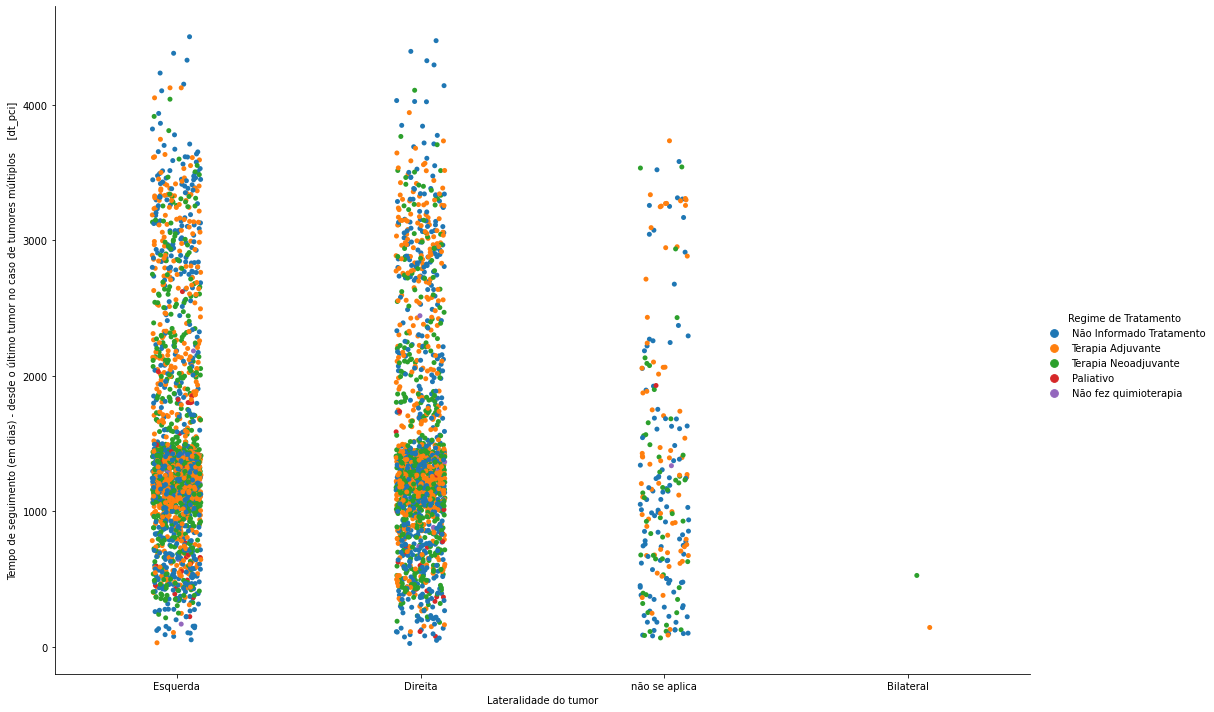

In [16]:
sns.catplot(data=tes2, x="Lateralidade do tumor", y="Tempo de seguimento (em dias) - desde o último tumor no caso de tumores múltiplos    [dt_pci]", hue='Regime de Tratamento', aspect=10.7/7.3, height=10)

# **CODIFICAÇÃO **

CODIFICAÇÃO IDADE (label) E ÚLTIMA INFORMAÇÃO (one-hot)

In [17]:
pd.set_option('display.precision',1)

tes['Idade do paciente ao primeiro diagnóstico'] = tes['Idade do paciente ao primeiro diagnóstico'].astype('int64')

tes['Idade COD'] = pd.cut(tes['Idade do paciente ao primeiro diagnóstico'], bins=[-1,1,30,45,60,89], labels=['-1','1','2','3','4'])
print(tes.shape)
#-1 -> NÃO INFORMADO
# 1 = Idade entre 1~30 anos
# 2 = Idade entre 30~45 anos
# 3 = Idade entre 45~60 anos
# 4 = Idade 60+ anos


(3726, 16)


<ipython-input-17-29f11694ced5>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tes['Idade do paciente ao primeiro diagnóstico'] = tes['Idade do paciente ao primeiro diagnóstico'].astype('int64')
<ipython-input-17-29f11694ced5>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tes['Idade COD'] = pd.cut(tes['Idade do paciente ao primeiro diagnóstico'], bins=[-1,1,30,45,60,89], labels=['-1','1','2','3','4'])


In [43]:
ohe = OneHotEncoder()
opa = ohe.fit_transform(tes['Última informação do paciente'].values.reshape(-1,1)).toarray()

dfohe = pd.DataFrame(opa, columns=['Óbito por Câncer','Vivo SOE', 'Vivo com Câncer', 'Óbito por outras causas SOE'])
dfohe.shape
df = pd.concat([tes,dfohe], axis=1)
df

[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 ...
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]]


,Record ID,Idade do paciente ao primeiro diagnóstico,Última informação do paciente,Tempo de seguimento (em dias) - desde o último tumor no caso de tumores múltiplos [dt_pci],Já ficou grávida?,Regime de Tratamento,Classificação TNM Clínico - M,Classificação TNM Clínico - N,Classificação TNM Clínico - T,Lateralidade do tumor,Com recidiva à distância,Com recidiva regional,Com recidiva local,Estadio Clínico,Combinação dos Tratamentos Realizados no Hospital,Idade COD,Óbito por Câncer,Vivo SOE,Vivo com Câncer,Óbito por outras causas SOE
0,302.0,51.0,Obito por câncer,2225.0,Não Informado Gravida,Não Informado Tratamento,0,0,2,Esquerda,Não,Não,Não,IIA,Cirurgia + Radio + Quimio + Hormonio,3,1.0,0.0,0.0,0.0
1,710.0,58.0,"Vivo, SOE",3294.0,Não Informado Gravida,Terapia Adjuvante,0,1,3,Esquerda,Não,Sim,Sim,IIIA,Cirurgia + Quimioterapia,3,0.0,1.0,0.0,0.0
2,752.0,56.0,"Vivo, SOE",4153.0,Não Informado Gravida,Não Informado Tratamento,0,0,2,Esquerda,Não,Não,Não,IIA,Outras combinações,3,0.0,1.0,0.0,0.0
3,1367.0,63.0,Obito por câncer,1331.0,Não Informado Gravida,Não Informado Tratamento,0,1,1,Esquerda,Não,Sim,Não,IIA,Outras combinações,4,1.0,0.0,0.0,0.0
4,1589.0,42.0,"Vivo, SOE",3290.0,Não Informado Gravida,Não Informado Tratamento,0,1,2,Direita,Não,Não,Não,IIB,Cirurgia + Radio + Quimio,2,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3741,82123.0,0.0,"Vivo, SOE",380.0,Não Informado Gravida,Terapia Neoadjuvante,0,0,2,Esquerda,Não,Não,Não,IIA,Outras combinações,-1,NaN,NaN,NaN,NaN
3742,82124.0,41.0,Obito por câncer,138.0,Sim,Não Informado Tratamento,0,0,CDIS,Direita,Não,Não,Não,0,Quimioterapia,2,NaN,NaN,NaN,NaN
3743,82131.0,59.0,Obito por câncer,900.0,Sim,Não Informado Tratamento,0,1,3,Direita,Não,Não,Não,IIIA,Cirurgia + Radioterapia,3,NaN,NaN,NaN,NaN
3744,82205.0,29.0,Obito por câncer,538.0,Não Informado Gravida,Não Informado Tratamento,1,1,4D,Esquerda,Não,Não,Sim,IV,Cirurgia + Radio + Quimio,1,NaN,NaN,NaN,NaN


CODIFICAÇÃO TEMPO DE SEGUIMENTO (LABEL)

In [19]:

df = df.drop(df[df['Tempo de seguimento (em dias) - desde o último tumor no caso de tumores múltiplos    [dt_pci]'] == 0].index)

df['Tempo ultimo tumor'] = pd.cut(df['Tempo de seguimento (em dias) - desde o último tumor no caso de tumores múltiplos    [dt_pci]'], bins=[0,365,730,1825,2920,4000], labels=['1','2','3','4','5'])


df

,Record ID,Idade do paciente ao primeiro diagnóstico,Última informação do paciente,Tempo de seguimento (em dias) - desde o último tumor no caso de tumores múltiplos [dt_pci],Já ficou grávida?,Regime de Tratamento,Classificação TNM Clínico - M,Classificação TNM Clínico - N,Classificação TNM Clínico - T,Lateralidade do tumor,...,Com recidiva regional,Com recidiva local,Estadio Clínico,Combinação dos Tratamentos Realizados no Hospital,Idade COD,Óbito por Câncer,Vivo SOE,Vivo com Câncer,Óbito por outras causas SOE,Tempo ultimo tumor
0,302.0,51.0,Obito por câncer,2225.0,Não Informado Gravida,Não Informado Tratamento,0,0,2,Esquerda,...,Não,Não,IIA,Cirurgia + Radio + Quimio + Hormonio,3,1.0,0.0,0.0,0.0,4
1,710.0,58.0,"Vivo, SOE",3294.0,Não Informado Gravida,Terapia Adjuvante,0,1,3,Esquerda,...,Sim,Sim,IIIA,Cirurgia + Quimioterapia,3,0.0,1.0,0.0,0.0,5
2,752.0,56.0,"Vivo, SOE",4153.0,Não Informado Gravida,Não Informado Tratamento,0,0,2,Esquerda,...,Não,Não,IIA,Outras combinações,3,0.0,1.0,0.0,0.0,NaN
3,1367.0,63.0,Obito por câncer,1331.0,Não Informado Gravida,Não Informado Tratamento,0,1,1,Esquerda,...,Sim,Não,IIA,Outras combinações,4,1.0,0.0,0.0,0.0,3
4,1589.0,42.0,"Vivo, SOE",3290.0,Não Informado Gravida,Não Informado Tratamento,0,1,2,Direita,...,Não,Não,IIB,Cirurgia + Radio + Quimio,2,0.0,1.0,0.0,0.0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3741,82123.0,0.0,"Vivo, SOE",380.0,Não Informado Gravida,Terapia Neoadjuvante,0,0,2,Esquerda,...,Não,Não,IIA,Outras combinações,-1,NaN,NaN,NaN,NaN,2
3742,82124.0,41.0,Obito por câncer,138.0,Sim,Não Informado Tratamento,0,0,CDIS,Direita,...,Não,Não,0,Quimioterapia,2,NaN,NaN,NaN,NaN,1
3743,82131.0,59.0,Obito por câncer,900.0,Sim,Não Informado Tratamento,0,1,3,Direita,...,Não,Não,IIIA,Cirurgia + Radioterapia,3,NaN,NaN,NaN,NaN,3
3744,82205.0,29.0,Obito por câncer,538.0,Não Informado Gravida,Não Informado Tratamento,1,1,4D,Esquerda,...,Não,Sim,IV,Cirurgia + Radio + Quimio,1,NaN,NaN,NaN,NaN,2


CODIFICAÇÃO "JÁ FICOU GRÁVIDA" (ONE-HOT)

In [20]:
df['Já ficou grávida?'].fillna("Não Informado Gravida", inplace= True)
ohegravida = ohe.fit_transform(df['Já ficou grávida?'].values.reshape(-1,1)).toarray()

df_ohegravida = pd.DataFrame(ohegravida, columns=['Não Grávida','Não informado Grávida','Grávida'])

df = pd.concat([df,df_ohegravida], axis=1)

CODIFICAÇÃO "REGIME DE TRATAMENTO" (ONE-HOT)

In [21]:
df['Regime de Tratamento'].fillna("Não Informado Tratamento", inplace= True)
ohetrat = ohe.fit_transform(df['Regime de Tratamento'].values.reshape(-1,1)).toarray()


df_ohetrat = pd.DataFrame(ohetrat, columns=['Tratamento Não Informado','Não fez Quimioterapia','Paliativo','Terapia Adjuvante','Terapia Neoadjuvante'])
df = pd.concat([df,df_ohetrat], axis=1)



CODIFICAÇÃO "LATERALIDADE DO TUMOR"

In [22]:

df['Lateralidade do tumor'].fillna("Não Informado Lateralidade", inplace= True)
ohelateral = ohe.fit_transform(df['Lateralidade do tumor'].values.reshape(-1,1)).toarray()


df_ohelat = pd.DataFrame(ohelateral, columns=['Bilateral','Direita','Esquerda','Lateralidade Não informada','Lateralidade não se aplica'])

df = pd.concat([df,df_ohelat], axis=1)
df

,Record ID,Idade do paciente ao primeiro diagnóstico,Última informação do paciente,Tempo de seguimento (em dias) - desde o último tumor no caso de tumores múltiplos [dt_pci],Já ficou grávida?,Regime de Tratamento,Classificação TNM Clínico - M,Classificação TNM Clínico - N,Classificação TNM Clínico - T,Lateralidade do tumor,...,Tratamento Não Informado,Não fez Quimioterapia,Paliativo,Terapia Adjuvante,Terapia Neoadjuvante,Bilateral,Direita,Esquerda,Lateralidade Não informada,Lateralidade não se aplica
0,302.0,51.0,Obito por câncer,2225.0,Não Informado Gravida,Não Informado Tratamento,0,0,2,Esquerda,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,710.0,58.0,"Vivo, SOE",3294.0,Não Informado Gravida,Terapia Adjuvante,0,1,3,Esquerda,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,752.0,56.0,"Vivo, SOE",4153.0,Não Informado Gravida,Não Informado Tratamento,0,0,2,Esquerda,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1367.0,63.0,Obito por câncer,1331.0,Não Informado Gravida,Não Informado Tratamento,0,1,1,Esquerda,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1589.0,42.0,"Vivo, SOE",3290.0,Não Informado Gravida,Não Informado Tratamento,0,1,2,Direita,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3741,82123.0,0.0,"Vivo, SOE",380.0,Não Informado Gravida,Terapia Neoadjuvante,0,0,2,Esquerda,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3742,82124.0,41.0,Obito por câncer,138.0,Sim,Não Informado Tratamento,0,0,CDIS,Direita,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3743,82131.0,59.0,Obito por câncer,900.0,Sim,Não Informado Tratamento,0,1,3,Direita,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3744,82205.0,29.0,Obito por câncer,538.0,Não Informado Gravida,Não Informado Tratamento,1,1,4D,Esquerda,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


CODIFICAÇÃO DAS RECIDIVAS (BINARY)

In [23]:
df['Com recidiva local'].fillna("Não", inplace= True)
df['Recidiva Local'] = df['Com recidiva local']
df["Recidiva Local"] = np.where(df["Com recidiva local"] == "Não", 0, 1)

df['Com recidiva regional'].fillna("Não", inplace= True)
df['Recidiva Regional'] = df['Com recidiva regional']
df["Recidiva Regional"] = np.where(df["Com recidiva regional"] == "Não", 0, 1)

df['Com recidiva à distância'].fillna("Não", inplace= True)
df['Recidiva à distância'] = df['Com recidiva à distância']
df["Recidiva à distância"] = np.where(df["Com recidiva à distância"] == "Não", 0, 1)

df

,Record ID,Idade do paciente ao primeiro diagnóstico,Última informação do paciente,Tempo de seguimento (em dias) - desde o último tumor no caso de tumores múltiplos [dt_pci],Já ficou grávida?,Regime de Tratamento,Classificação TNM Clínico - M,Classificação TNM Clínico - N,Classificação TNM Clínico - T,Lateralidade do tumor,...,Terapia Adjuvante,Terapia Neoadjuvante,Bilateral,Direita,Esquerda,Lateralidade Não informada,Lateralidade não se aplica,Recidiva Local,Recidiva Regional,Recidiva à distância
0,302.0,51.0,Obito por câncer,2225.0,Não Informado Gravida,Não Informado Tratamento,0,0,2,Esquerda,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0,0
1,710.0,58.0,"Vivo, SOE",3294.0,Não Informado Gravida,Terapia Adjuvante,0,1,3,Esquerda,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1,1,0
2,752.0,56.0,"Vivo, SOE",4153.0,Não Informado Gravida,Não Informado Tratamento,0,0,2,Esquerda,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0,0
3,1367.0,63.0,Obito por câncer,1331.0,Não Informado Gravida,Não Informado Tratamento,0,1,1,Esquerda,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,1,0
4,1589.0,42.0,"Vivo, SOE",3290.0,Não Informado Gravida,Não Informado Tratamento,0,1,2,Direita,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3741,82123.0,0.0,"Vivo, SOE",380.0,Não Informado Gravida,Terapia Neoadjuvante,0,0,2,Esquerda,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0,0,0
3742,82124.0,41.0,Obito por câncer,138.0,Sim,Não Informado Tratamento,0,0,CDIS,Direita,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0,0
3743,82131.0,59.0,Obito por câncer,900.0,Sim,Não Informado Tratamento,0,1,3,Direita,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0,0
3744,82205.0,29.0,Obito por câncer,538.0,Não Informado Gravida,Não Informado Tratamento,1,1,4D,Esquerda,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,0,0


CODIFICAÇÃO "ESTADIO CLINICO" (LABEL)

In [24]:
label_encoder = LabelEncoder()
df['Estadio Clínico  '].fillna("IV", inplace= True)

df['Estadio Clínico COD'] = label_encoder.fit_transform(df['Estadio Clínico  '])
df['Estadio Clínico  '].unique()
df['Estadio Clínico COD'].value_counts()
# 0 - 0
# I - 1
# IA - 2
# IB - 3
# IB1 - 4
# IB2- 5
# II - 6
# IIA - 7
# IIB - 8
# IIC- 9
# III- 10
# IIIA - 11
# IIIB - 12
# IIIC - 13
# IV - 14
# IVA - 15
# IVB - 16
# IVC - 17
# Y: NA - 18
# X : não foi possivel determinar - 19

7     797
8     581
11    577
14    467
2     392
12    369
1     225
13    150
0      81
3      38
19     16
10     14
6      13
15      8
16      7
18      7
4       1
17      1
9       1
5       1
Name: Estadio Clínico COD, dtype: int64

CODIFICAÇÃO "COMBINAÇÃO DE TRATAMENTOS" (ONE HOT)

In [25]:

df['Combinação dos Tratamentos Realizados no Hospital'].fillna("Nenhum tratamento", inplace= True)

ohecombtrat = ohe.fit_transform(df['Combinação dos Tratamentos Realizados no Hospital'].values.reshape(-1,1)).toarray()


df_combtrat = pd.DataFrame(ohecombtrat, columns=['C','C+Q','C+R+Q','C+R+Q+H','C+R','Nenhum Tratamento','Outras Combinações','Q','R','R+Q'])
# C = CIRURGIA
# Q = QUIMIOTERAPIA
# R = RADIOTERIA
# H = HORMONIOTERAPIA


df = pd.concat([df,df_combtrat], axis=1)

df

,Record ID,Idade do paciente ao primeiro diagnóstico,Última informação do paciente,Tempo de seguimento (em dias) - desde o último tumor no caso de tumores múltiplos [dt_pci],Já ficou grávida?,Regime de Tratamento,Classificação TNM Clínico - M,Classificação TNM Clínico - N,Classificação TNM Clínico - T,Lateralidade do tumor,...,C,C+Q,C+R+Q,C+R+Q+H,C+R,Nenhum Tratamento,Outras Combinações,Q,R,R+Q
0,302.0,51.0,Obito por câncer,2225.0,Não Informado Gravida,Não Informado Tratamento,0,0,2,Esquerda,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,710.0,58.0,"Vivo, SOE",3294.0,Não Informado Gravida,Terapia Adjuvante,0,1,3,Esquerda,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,752.0,56.0,"Vivo, SOE",4153.0,Não Informado Gravida,Não Informado Tratamento,0,0,2,Esquerda,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,1367.0,63.0,Obito por câncer,1331.0,Não Informado Gravida,Não Informado Tratamento,0,1,1,Esquerda,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,1589.0,42.0,"Vivo, SOE",3290.0,Não Informado Gravida,Não Informado Tratamento,0,1,2,Direita,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3741,82123.0,0.0,"Vivo, SOE",380.0,Não Informado Gravida,Terapia Neoadjuvante,0,0,2,Esquerda,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3742,82124.0,41.0,Obito por câncer,138.0,Sim,Não Informado Tratamento,0,0,CDIS,Direita,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3743,82131.0,59.0,Obito por câncer,900.0,Sim,Não Informado Tratamento,0,1,3,Direita,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3744,82205.0,29.0,Obito por câncer,538.0,Não Informado Gravida,Não Informado Tratamento,1,1,4D,Esquerda,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


CODIFICAÇÃO TNM - M (LABEL)

In [26]:

df['Classificação TNM Clínico - M'].fillna("X - nao foi possivel determinar", inplace= True)

df['Classificação TNM - M'] = label_encoder.fit_transform(df['Classificação TNM Clínico - M'])

df
#0 - 0
#1 - 1
#2 - 1A
#3 - 1B
#4 - X - nao foi possivel determinar
#5 - Y: na


df['Classificação TNM - M'].value_counts()

0    3249
1     445
4      27
5      16
3       6
2       3
Name: Classificação TNM - M, dtype: int64

CODIFICAÇÃO TNM - N (LABEL)

In [27]:

df['Classificação TNM Clínico - N'].fillna("X - nao foi possivel determinar", inplace= True)

df['Classificação TNM - N'] = label_encoder.fit_transform(df['Classificação TNM Clínico - N'])


# 0 - 0 
# 1 - 1
# 2 - 1A
# 3 - 1B
# 4 - 2
# 5 - 2A
# 6 - 2B
# 7 - 3
# 8 - 3A
# 9 - 3B
# 10 - 3C
# 11 - X -nao foi possivel determinar
# 12 - Y: Na


df.isnull().sum()


Record ID                                                                                        20
Idade do paciente ao primeiro diagnóstico                                                        20
Última informação do paciente                                                                    20
Tempo de seguimento (em dias) - desde o último tumor no caso de tumores múltiplos    [dt_pci]    20
Já ficou grávida?                                                                                 0
Regime de Tratamento                                                                              0
Classificação TNM Clínico - M                                                                     0
Classificação TNM Clínico - N                                                                     0
Classificação TNM Clínico - T                                                                    20
Lateralidade do tumor                                                                             0


CODIFICAÇÃO TNM - T (LABEL)

In [28]:


df['Classificação TNM Clínico - T'].fillna("X - nao foi possivel determinar", inplace= True)

df['Classificação TNM - T'] = label_encoder.fit_transform(df['Classificação TNM Clínico - T'])


# 0 - 0
# 1 - 1
# 2 - 1A
# 3 - 1B
# 4 - 1C
# 5 - 1MIC
# 6 - 2
# 7 - 2A
# 8 - 2B
# 9 - 3
# 10 - 3A 
# 11 - 3B
# 12 - 4
# 13 - 4A
# 14 - 4B
# 15 - 4C
# 16 - 4D
# 17 - CDIS
# 18 - CLIS
# 19 - IS
# 20 - X - nao foi possivel determinar
# 21 - Y: Na
 
df['Classificação TNM - T'].value_counts()

6     1367
9      698
4      502
14     396
1      138
3      130
12     109
16     102
2       73
20      63
19      52
17      27
13      26
15      26
21      16
7        6
5        4
10       3
11       3
0        2
8        2
18       1
Name: Classificação TNM - T, dtype: int64

TRATAMENTO DE MISSINGS OCORRIDOS DEVIDO A UM BUG DO ONEHOT ENCODED

E 

SEPARAÇÃO ENTRE DOIS DF's -> UM POSSUI SOMENTE AS COLUNAS CODIFICADAS E O OUTRO POSSUI TODAS

In [29]:
df.isnull().sum()
df.columns[15]

df_x = df.iloc[:,15:52]

df_x = df_x.dropna(subset=['Vivo com Câncer','Grávida', 'Idade COD', 'Tempo ultimo tumor'])

df_x.isnull().sum()

Idade COD                      0
Óbito por Câncer               0
Vivo SOE                       0
Vivo com Câncer                0
Óbito por outras causas SOE    0
Tempo ultimo tumor             0
Não Grávida                    0
Não informado Grávida          0
Grávida                        0
Tratamento Não Informado       0
Não fez Quimioterapia          0
Paliativo                      0
Terapia Adjuvante              0
Terapia Neoadjuvante           0
Bilateral                      0
Direita                        0
Esquerda                       0
Lateralidade Não informada     0
Lateralidade não se aplica     0
Recidiva Local                 0
Recidiva Regional              0
Recidiva à distância           0
Estadio Clínico COD            0
C                              0
C+Q                            0
C+R+Q                          0
C+R+Q+H                        0
C+R                            0
Nenhum Tratamento              0
Outras Combinações             0
Q         

# **DESENVOLVIMENTO DE HIPÓTESES **

**1a Hipótese** -> Com base nos dados que possuimos e analisando-os graficamente, podemos analisar que pacientes na faixa etária de 40-60 que nunca ficaram grávidas possuem alto risco de morte.

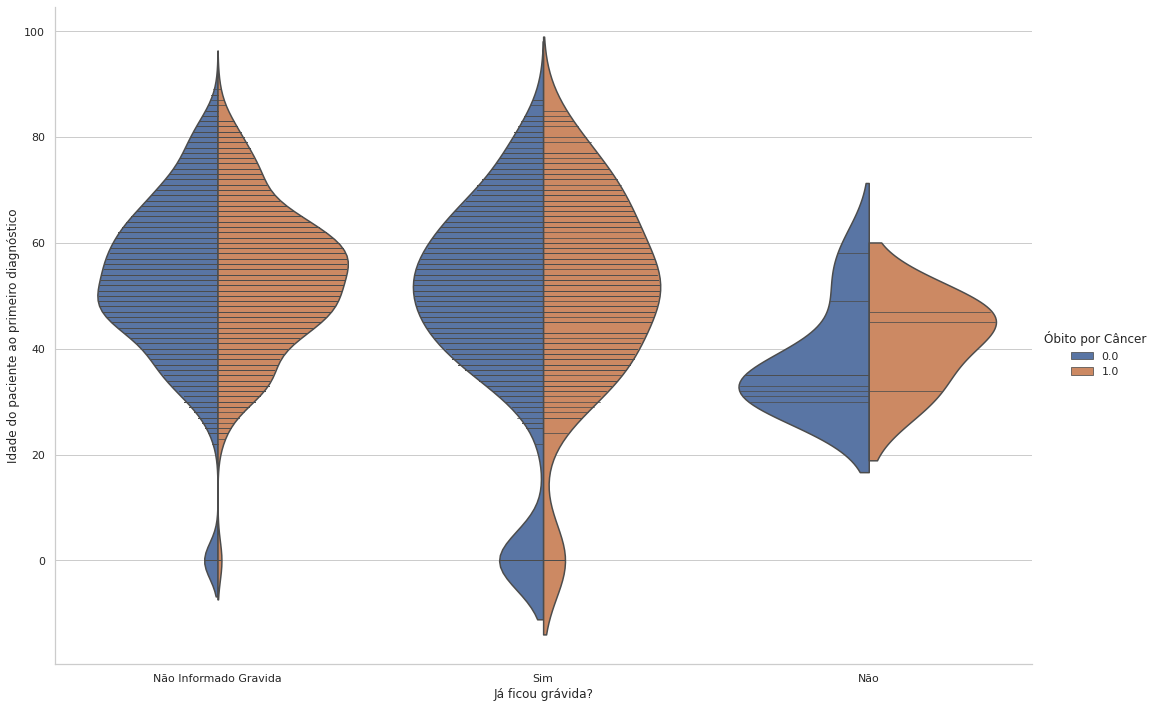

In [30]:
sns.set_theme(style="whitegrid")

#fig, axes = plt.subplots(1,2, sharex=True, figsize=(25,5))
sns.catplot(data=df,kind='violin',inner='stick',split=True ,x='Já ficou grávida?', y='Idade do paciente ao primeiro diagnóstico',hue='Óbito por Câncer', aspect=10.7/7.3, height=10)

**2a Hipótese** -> Para as pessoas do grupo de estadio clínico IV que estejam perto do 60 anos, o tratamento indicado é o tratamento adjuvante, já que podemos ver no gráfico, um pico de pessoas sobevivendo, muito acima do outro cenário (morte).

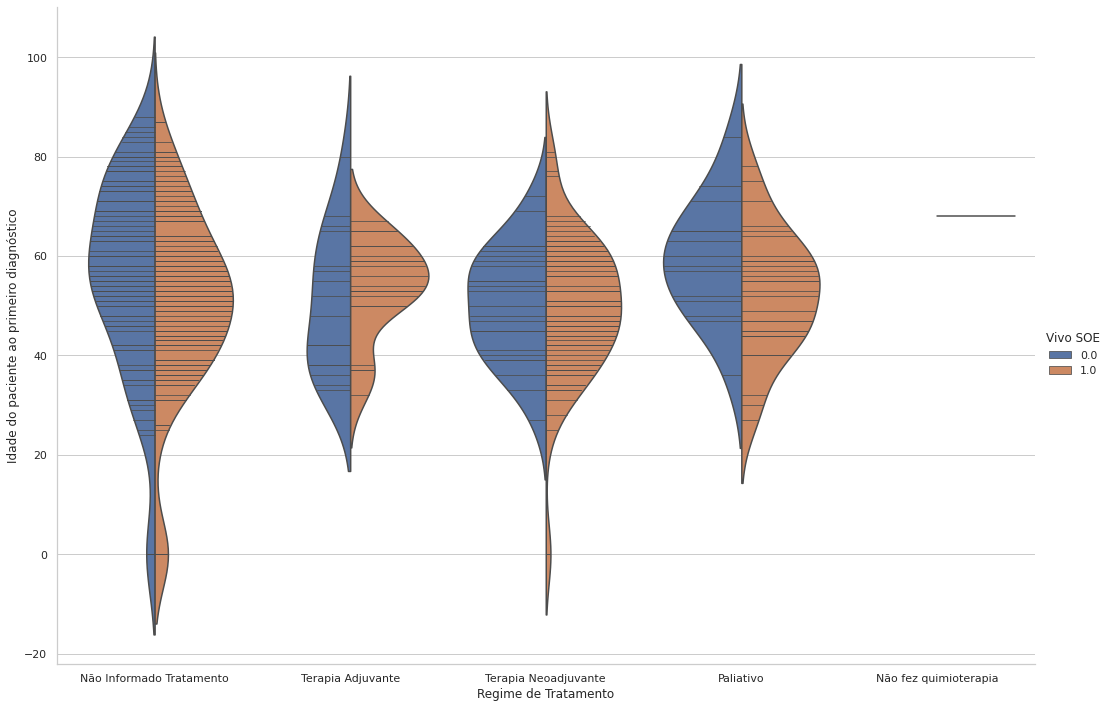

In [31]:
#Tempo de seguimento (em dias) - desde o último tumor no caso de tumores múltiplos [dt_pci]

tt = df[(df['Estadio Clínico COD'] == 14)]
sns.catplot(data=tt,kind='violin',inner='stick',split=True ,x='Regime de Tratamento', y='Idade do paciente ao primeiro diagnóstico',hue='Vivo SOE', aspect=10.7/7.3, height=10)

**3a Hipótese** ->  O tratamento adjuvante não é indicado para pacientes na faixa etária entre 45~60 que estão no estadio clínico IIA. Conforme podemos analisar no gráfico abaixo, há um curva bastante acentuada para pessoas nessa idade.

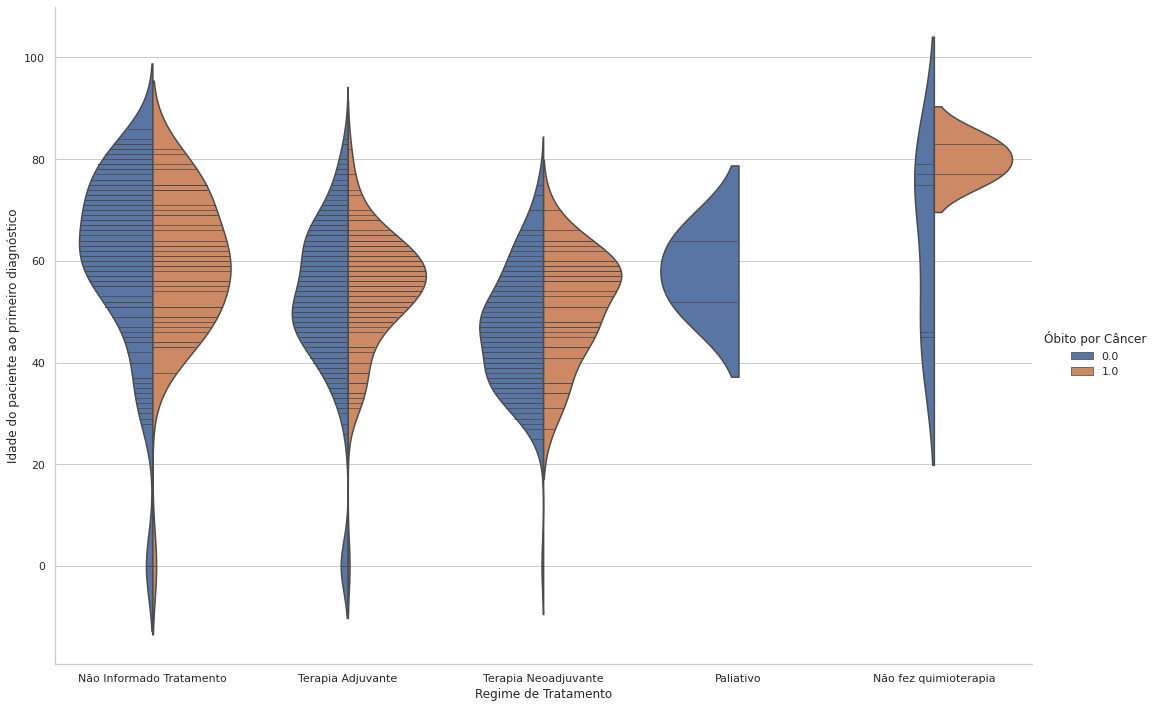

In [32]:
#sns.catplot(data=rr,kind='violin',inner='stick',split=True ,x='Regime de Tratamento', y='Idade do paciente ao primeiro diagnóstico',hue='Vivo SOE', aspect=10.7/7.3, height=10)

rr = df[(df['Estadio Clínico COD'] == 7)]
sns.catplot(data=rr,kind='violin',inner='stick',split=True ,x='Regime de Tratamento', y='Idade do paciente ao primeiro diagnóstico',hue='Óbito por Câncer', aspect=10.7/7.3, height=10)
#index_diastumor = tes2[ (tes2['Tempo de seguimento (em dias) - desde o último tumor no caso de tumores múltiplos    [dt_pci]'] <= 20)].index
